# Предобработка данных

In [29]:
import pandas as pd

df = pd.read_csv("data/NFLX.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-16,119.800003,123.000000,118.089996,122.639999,122.639999,13181000
1,2015-12-17,123.970001,126.349998,122.419998,122.510002,122.510002,17284900
2,2015-12-18,120.849998,122.190002,117.919998,118.019997,118.019997,17948100
3,2015-12-21,119.510002,119.589996,115.660004,116.629997,116.629997,11670000
4,2015-12-22,117.300003,117.430000,114.860001,116.239998,116.239998,9689000


Отобразим колонку High на графике

<AxesSubplot:title={'center':'Original'}, ylabel='Value'>

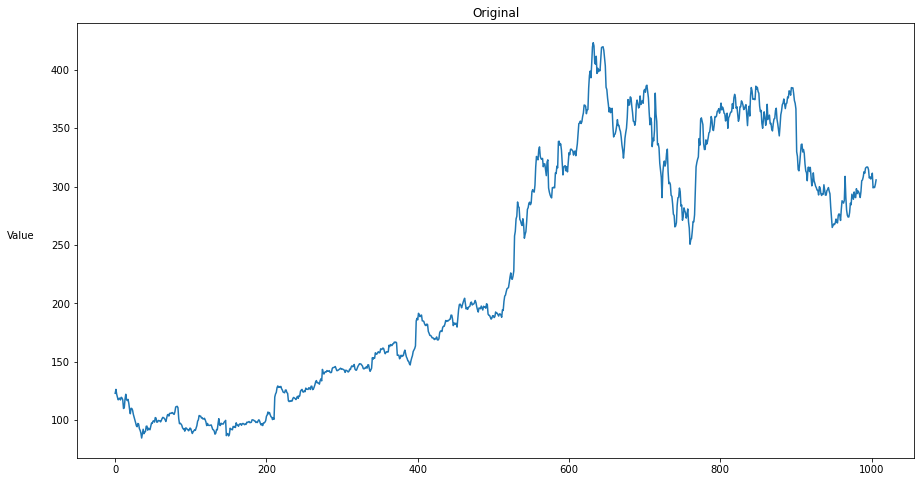

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.title("Original")
plt.ylabel('Value', rotation=0, labelpad=30)
df['High'].plot()

Вместо значения за каждый день будем отображать значения за месяц

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-16,119.800003,123.000000,118.089996,122.639999,122.639999,13181000
25,2016-01-25,99.779999,102.680000,99.000000,99.120003,99.120003,20321100
50,2016-03-01,94.580002,99.160004,93.610001,98.300003,98.300003,17048800
75,2016-04-06,105.300003,106.440002,104.250000,104.830002,104.830002,9605800
100,2016-05-11,92.400002,92.589996,89.900002,90.019997,90.019997,11692900


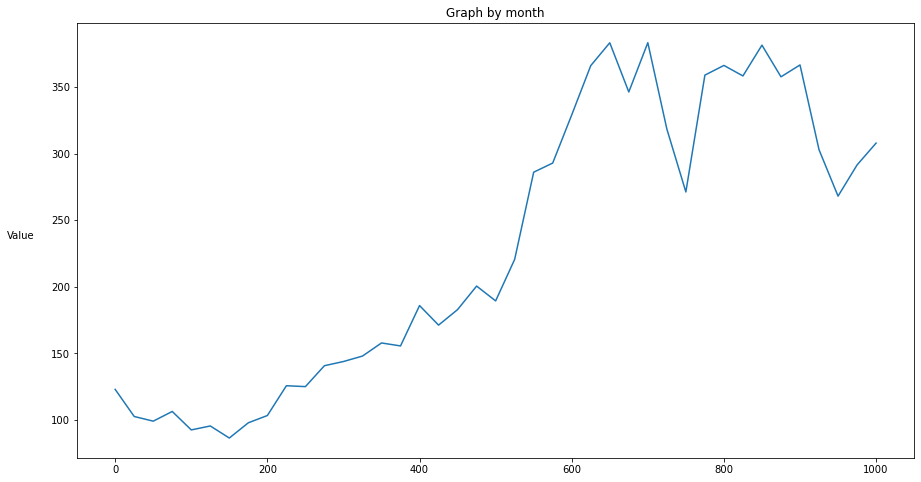

In [32]:
df = df.iloc[::25, :]

plt.figure(figsize=(15, 8))
plt.title('Graph by month')
plt.ylabel('Value', rotation=0, labelpad=30)
df['High'].plot()
df.head()

Заменим обычные индексы на полную дату

In [33]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

df = df.set_index(['Date'])
df.sort_index(inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-16,119.800003,123.000000,118.089996,122.639999,122.639999,13181000
2016-01-25,99.779999,102.680000,99.000000,99.120003,99.120003,20321100
2016-03-01,94.580002,99.160004,93.610001,98.300003,98.300003,17048800
2016-04-06,105.300003,106.440002,104.250000,104.830002,104.830002,9605800
2016-05-11,92.400002,92.589996,89.900002,90.019997,90.019997,11692900


Посмотрим, что действительно наши индексы теперь - даты

<AxesSubplot:title={'center':'Graph by month'}, xlabel='Date', ylabel='Value'>

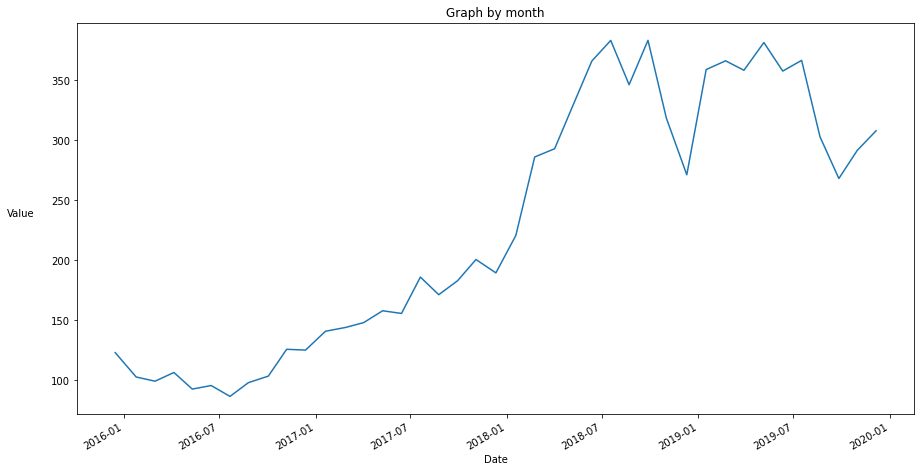

In [35]:
plt.figure(figsize=(15, 8))
plt.title('Graph by month')
plt.ylabel('Value', rotation=0, labelpad=30)
df['High'].plot()

# Исследование на наличие тренда

По нашим данным построим оригинальный график, график треда, сезонный график(посморим, есть ли тренд и сезонность) и построим график ошибоки(отклонений от тренда)

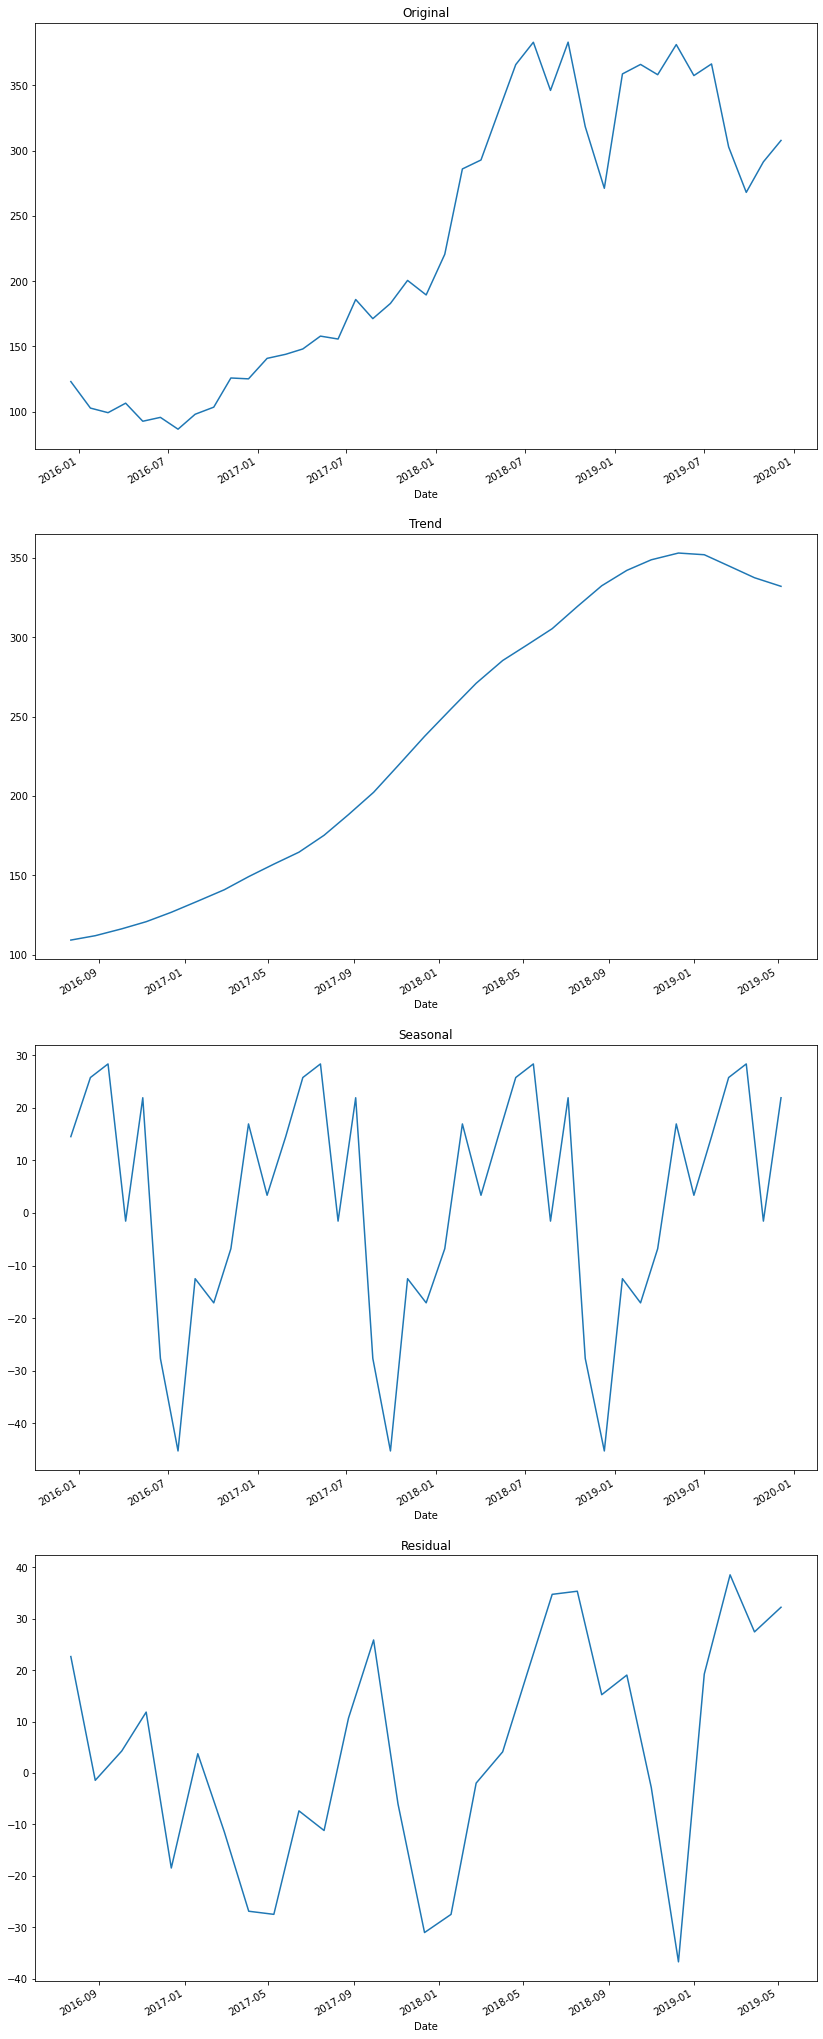

In [37]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# Разложим ряд на компоненты и проверим ответы на вопросы
SHIFT = 12

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df[['High']], period=SHIFT)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

# Избавляемся от тренда

Избавимся от тренда. Для этого логорифмируем все данные и построим график

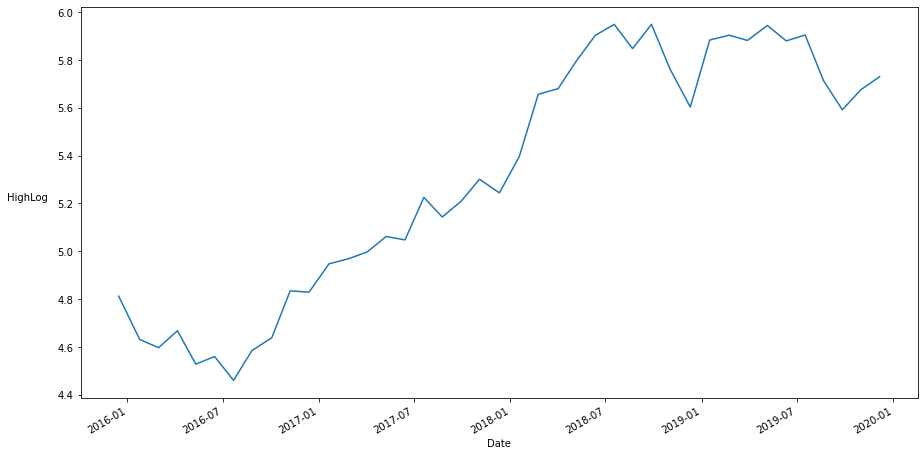

In [38]:
import numpy as np

df['HighLog'] = np.log(df['High'])

plt.figure(figsize=(15, 8))
plt.ylabel('HighLog', rotation=0, labelpad=30)
df['HighLog'].plot();

Строим дифференцируемый график(разность i и + shift позиции). С помощью теста Дики-Фуллера проверим график на стационарность. Ряд получается стационарный(нулевая гипотеза не отвергнута, есть тренд)

Полученный уровень значимости (p-value): 0.8917. 0.8917 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


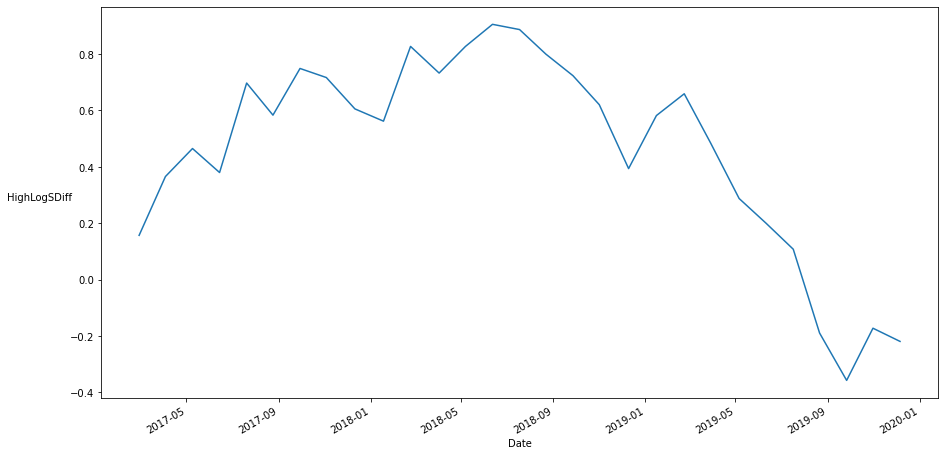

In [40]:
from statsmodels.tsa.stattools import adfuller

df['HighLogSDiff'] = df['HighLog'] - df['HighLog'].shift(SHIFT)
p_value = adfuller(df["HighLogSDiff"][SHIFT:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергается в пользу альтернативной!'
)

plt.figure(figsize=(15, 8))
plt.ylabel('HighLogSDiff', rotation=0, labelpad=30)
df['HighLogSDiff'].plot();

Построим коррелограммы. Построим график автокорреляции и частничной автокорелляции. Видим, что на первом графике столбцы(значения автокорреляций) входят в синюю зону => являются значимыми. На втором некоторые не входят

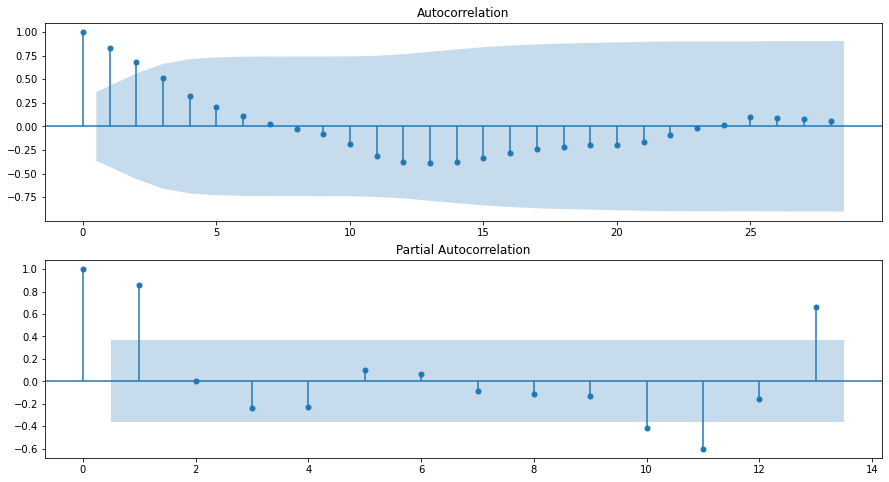

In [51]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(15,8))

ax = plt.subplot(211)
statsmodels.graphics.tsaplots.plot_acf(df['HighLogSDiff'][SHIFT:], lags=28, ax=ax)

ax = plt.subplot(212)
statsmodels.graphics.tsaplots.plot_pacf(df['HighLogSDiff'][SHIFT:], lags=13, ax=ax);

# Предсказание

Создаём наборы аргументов. Делим HighLog и High на тестовую и тестовую выборку

In [64]:
d=1
D=range(0,2)

qs = range(1, 4)
Qs = range(1, 3)

ps = range(1, 4)
Ps = range(3, 5)

size = len(df.HighLog)
index = int(0.8 * size)

X_train = df['HighLog'][:index]
X_test = df['HighLog'][index:]
y_train = df['High'][:index]
y_test = df['High'][index:]

In [66]:
X_train.head()

Date
2015-12-16    4.812184
2016-01-25    4.631617
2016-03-01    4.596735
2016-04-06    4.667581
2016-05-11    4.528181
Name: HighLog, dtype: float64

In [65]:
from itertools import product

parameters = product(ps, qs, Ps, D, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

Пытаемся тренировать алгоритм SARIMAX

In [67]:
%%time
#warnings.filterwarnings('ignore')

import statsmodels.api as sm
from tqdm import tqdm

results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            X_train,
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], param[3], param[4], 6)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

#warnings.filterwarnings('default')

  0%|          | 0/72 [00:00<?, ?it/s]/home/mtukallo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/mtukallo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/mtukallo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/mtukallo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: No

CPU times: user 58.1 s, sys: 256 ms, total: 58.3 s
Wall time: 47.8 s


Получаем результаты и выбираем из них лучший

In [69]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

         parameters        aic
0   (1, 1, 3, 0, 1) -33.194657
8   (1, 2, 3, 0, 1) -31.670387
1   (1, 1, 3, 0, 2) -31.668613
16  (1, 3, 3, 0, 1) -31.215944
56  (3, 2, 3, 0, 1) -31.202899


Выводим некоторую информацию о модели с лучшим набором аргументов

In [70]:
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           HighLog   No. Observations:                   32
Model:             SARIMAX(1, 1, 1)x(3, 0, 1, 6)   Log Likelihood                  23.597
Date:                           Mon, 22 Nov 2021   AIC                            -33.195
Time:                                   22:54:38   BIC                            -23.157
Sample:                                        0   HQIC                           -29.923
                                            - 32                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9043      0.362     -2.497      0.013      -1.614      -0.194
ma.L1          0.9936      1.838      0.541

Стриом график отклонений и автокорреляции по лучшей модели

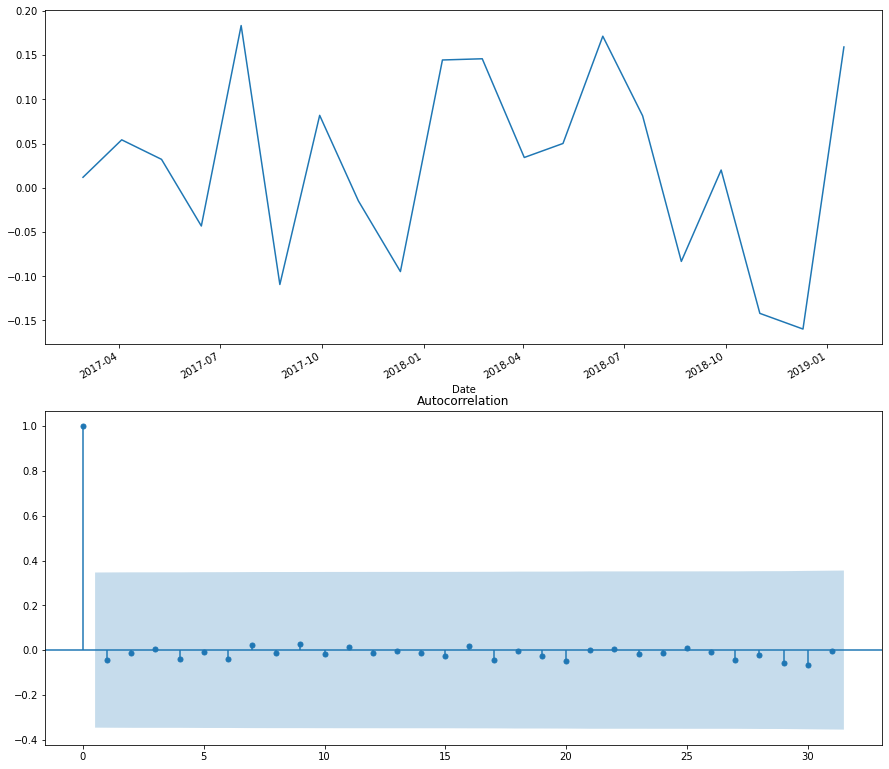

In [72]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[SHIFT:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=31, ax=ax);

Нарисуем график результата на тренировочной выборке

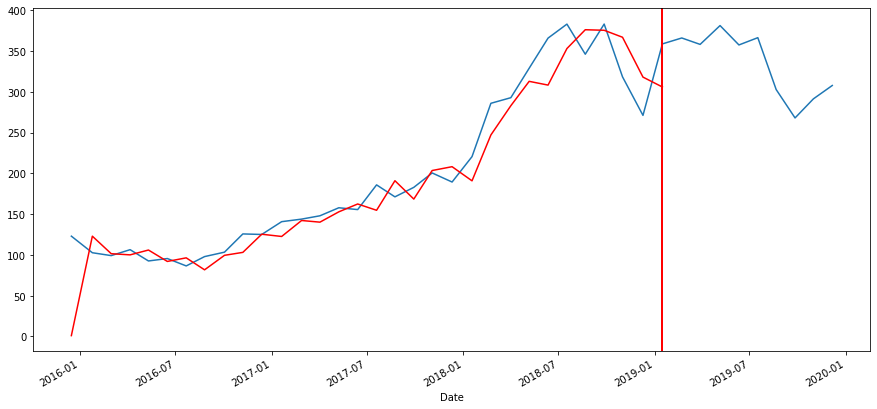

In [81]:
df['Model'] = np.exp(best_model.fittedvalues)

plt.figure(figsize=(15,7))

df['High'].plot()
df['Model'].plot(c='r');
plt.axvline(pd.to_datetime('2019-01-15'), color='r', linestyle='-', lw=2)

# Тестирование модели

Подготовим future датафрейм с колонками High и Model

In [108]:
import datetime
from dateutil.relativedelta import relativedelta

PREDICT_LEN = 10
DATASET_SIZE = df.shape[0]

new_close_value = df[['High', 'Model']]
future_date = [
    datetime.datetime.strptime("2019-12-06", "%Y-%m-%d") + relativedelta(months=x)
    for x in range(0, PREDICT_LEN)
]

future_df = pd.DataFrame(index=future_date, columns=['High', 'Model'])
new_close_value = pd.concat([new_close_value, future_df])

print(new_close_value.shape)
new_close_value.tail()

(51, 2)


,High,Model
2020-05-06,NaN,NaN
2020-06-06,NaN,NaN
2020-07-06,NaN,NaN
2020-08-06,NaN,NaN
2020-09-06,NaN,NaN


Пытаемся предсказывать продолжение на тестовой выборке. В созданный выше датафрейм запсываем значения

/home/mtukallo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/mtukallo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/mtukallo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/mtukallo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

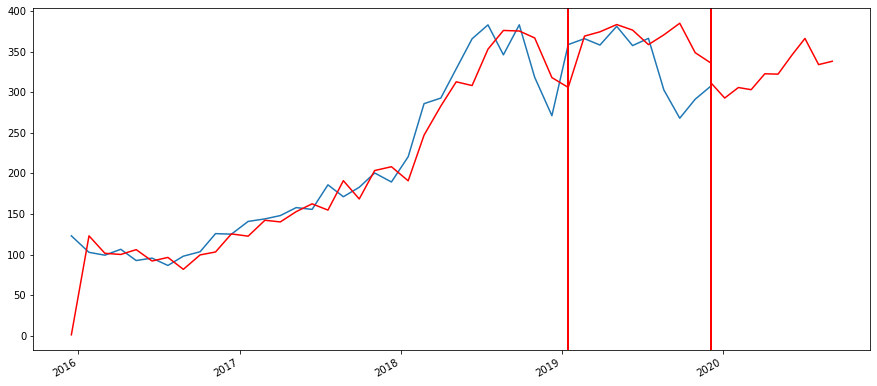

In [109]:
for i in range(DATASET_SIZE - PREDICT_LEN, DATASET_SIZE + PREDICT_LEN):
    new_close_value.iloc[i]['Model'] = np.exp(best_model.predict(i))

plt.figure(figsize=(15,7))
new_close_value['High'].plot()
new_close_value['Model'].plot(c='r');
plt.axvline(pd.to_datetime('2019-01-15'), color='r', linestyle='-', lw=2)
plt.axvline(pd.to_datetime('2019-12-06'), color='r', linestyle='-', lw=2)

# Метрика

Получили метрику MAPE

In [110]:
predicted_df = new_close_value.iloc[DATASET_SIZE - PREDICT_LEN : DATASET_SIZE]
actual = predicted_df['High'].to_numpy()
predicted = predicted_df['Model'].to_numpy()

In [111]:
def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

print("MAPE: ", mape(actual, predicted))

MAPE:  12.31070143352799
